<a href="https://colab.research.google.com/github/crimama/DL_study/blob/main/unet_practice_mri_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 다운로드 

In [1]:
!cp ./drive/MyDrive/데이터보관/mri_images/MRI_images.zip ./

In [ ]:
!unzip /content/MRI_images.zip

# 데이터 로드 

## 파일명 리스트 만들기 

In [3]:
data_path = '/content/MRI_images'

In [4]:
import os 
files = os.listdir(data_path)

In [5]:
#tif, mask 문자열이 제외 된 파일 리스트 만들기 
files_list = []
for i in range(len(files)):
  temp = files[i]
  temp = temp.replace('.tif','').replace('_mask','')
  files_list.append(temp)

## 파일명 리스트로 데이터 불러오기

In [6]:
i = 0 
temp = files_list[i]
print(temp)

TCGA_CS_5396_20010302_18


In [7]:
from skimage.io import imread
import matplotlib.pyplot as plt 
temp_img = imread(data_path+'/'+temp + '.tif')

In [8]:
#이미지 불러 오기 
images = []
for temp in files_list:
  try:  
    temp_img = imread(data_path+'/'+temp + '.tif')
    images.append(temp_img)
  except:
    print('nono')
    pass
import numpy as np 
images = np.array(images)
images.shape

nono


(436, 256, 256, 3)

In [9]:
#라벨 불러 오기 
labels = []
for temp in files_list:
  try:  
    temp_img = imread(data_path+'/'+temp +'_mask'+'.tif')
    labels.append(temp_img)
  except:
    print('nono')
    pass
import numpy as np 
labels = np.array(labels)
labels = labels.reshape(436,256,256,1)
labels.shape

nono


(436, 256, 256, 1)

## 데이터확인

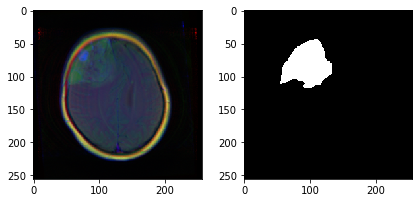

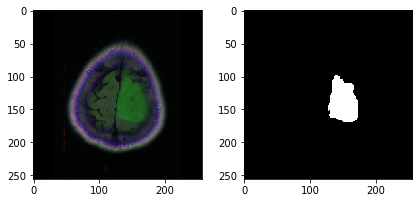

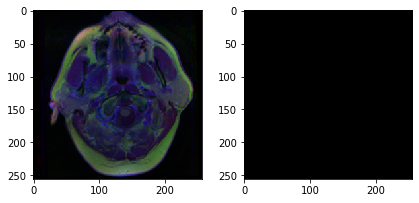

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


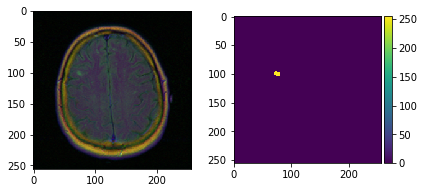

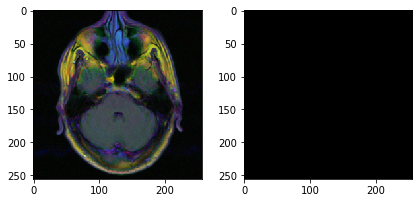

In [10]:
from skimage.io import imshow
for i in range(5):
  plt.subplot(1,2,1)
  imshow(images[i])
  plt.subplot(1,2,2)
  imshow(labels[i].squeeze())
  plt.show()

In [ ]:
print(np.max(labels),np.min(labels))

255 0


# 전처리 

## 정규화

(array([61756.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,  3780.]),
 array([  0.        ,   5.66666667,  11.33333333,  17.        ,
         22.66666667,  28.33333333,  34.        ,  39.66666667,
         45.33333333,  51.        ,  56.66666667,  62.33333333,
         68.        ,  73.66666667,  79.33333333,  85.        ,
         90.66666667,  96.33333333, 102.        , 107.66666667,
        113.33333333, 119.        , 124.66666667, 130.33333333,
        136.        , 141.66666667, 147.33333333, 153.        ,
        158.66666667, 164.33333333, 170.        , 175.66666667,
        181.33333333, 187.        , 192.66666667, 198.33333333,
        204.  

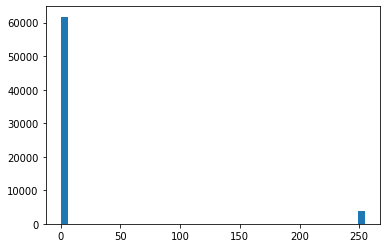

In [28]:
plt.hist(temp.flatten(),bins=45)

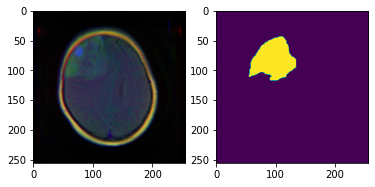

In [11]:
plt.subplot(1,2,1)
plt.imshow(images[0])
plt.subplot(1,2,2)
plt.imshow(labels[0].squeeze())

In [38]:
raw_x = (images/255).astype(np.float)
raw_y = (labels/255).astype(np.int)

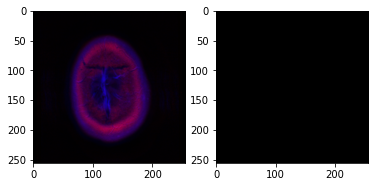

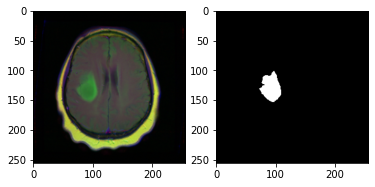

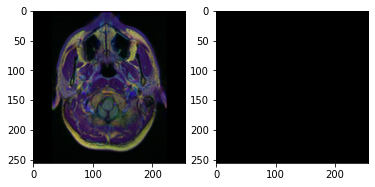

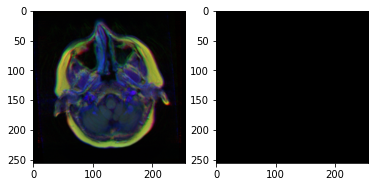

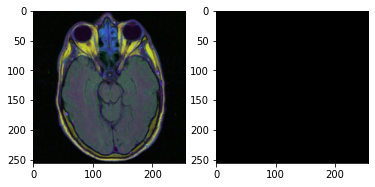

In [ ]:
for i in range(30,35):
  plt.subplot(1,2,1)
  plt.imshow(raw_x[i])
  plt.subplot(1,2,2)
  plt.imshow(raw_y[i].squeeze(),cmap = 'gray')
  plt.show()

## 데이터 분할 

In [41]:
from sklearn.model_selection import train_test_split
train_x,test_x, train_y,test_y = train_test_split(raw_x,raw_y, random_state=42)

In [42]:
print(train_x.shape,train_y.shape)

(327, 256, 256, 3) (327, 256, 256, 1)


In [ ]:
# std = np.int(len(raw_x)/4)

In [ ]:
# import pickle
# shape = raw_x.shape
# raw_x = raw_x.reshape(-1,shape[1]*shape[2]*shape[3])
# for i in range(4):
#   with open(f'df_x{i}','wb') as f:
#     pickle.dump(raw_x[i*std:(i+1)*std],f,pickle.HIGHEST_PROTOCOL)
#   print(i*std,(i+1)*std)
# del raw_x, shape

In [ ]:
# shape = raw_y.shape
# raw_y = raw_y.reshape(-1,shape[1]*shape[2]*shape[3])
# for i in range(4):
#   with open(f'df_y{i}','wb') as f:
#     pickle.dump(raw_y[i*std:(i+1)*std],f,pickle.HIGHEST_PROTOCOL)
#   print(i*std,(i+1)*std)
# del raw_y, shape

0 109
109 218
218 327
327 436


# 모델 

## unet 모듈 - binary 케이스 사용 

In [43]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(input_size=(256,256,3)): #train_x, test_x 는 256,256,3의 shape을 가져야 함 
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up, conv4], axis=3) # <---------- Conv4 를 넣음 
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up, conv3], axis=3) # <------------ Conv 3를 넣음 
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up, conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8) #<--- maxpooling과 반대의 역할을 함, 앞선 conv1과 반대의 작용을 하기 때문 
    up9 = concatenate([up, conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9) #<-------- 1장으로 만듬 

    return Model(inputs=[inputs], outputs=[conv10])

## 이미지 데이터 제너레이터 

In [ ]:
# model = unet()
# model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])
# history =[] 
# for i in range(4):
#   raw_x = pd.read_pickle(f'df_x{i}')
#   raw_x = raw_x.reshape(-1,256,256,3)

#   raw_y = pd.read_pickle(f'df_y{i}')
#   raw_y = raw_y.reshape(-1,256,256,1)

#   from sklearn.model_selection import train_test_split
#   train_x,test_x, train_y,test_y = train_test_split(raw_x,raw_y, random_state=42)

#   hist = model.fit(train_x,train_y, validation_split=0.2, epochs=20, batch_size=16, verbose=1)
#   history.append(hist)

Epoch 1/20


In [ ]:
model = unet()

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

hist = model.fit(train_x, train_y, validation_split = 0.2, epochs = 100, batch_size = 32, verbose=1)

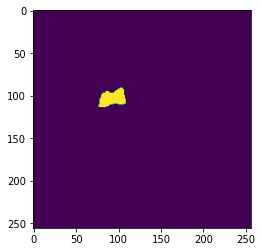

In [63]:
plt.imshow(train_y[0].squeeze())

In [60]:
y_ = model.predict(train_x)
temp = y_[0]

In [61]:
temp[temp<0.5]=0
temp[temp>=0.5]=1

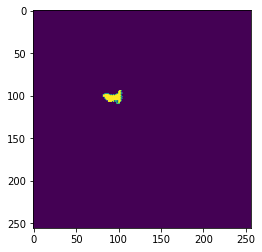

In [62]:
plt.imshow(temp.squeeze())

## 예측 

In [ ]:
y_ = model.predict(train_x)

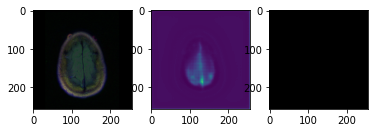

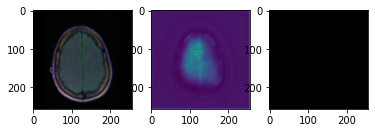

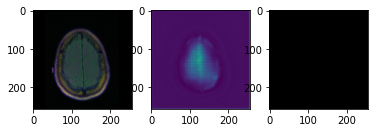

In [ ]:
for i in range(5,8):
  plt.subplot(1,3,1)
  plt.imshow(train_x[i])
  plt.subplot(1,3,2)
  plt.imshow(y_[i].squeeze())
  plt.subplot(1,3,3)
  plt.imshow((train_y[i]*255).squeeze(),'gray')
  plt.show()

In [ ]:
temp = images[:2].shape

In [ ]:
temp_y_ = model.predict(images)

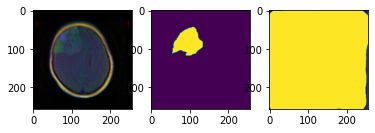

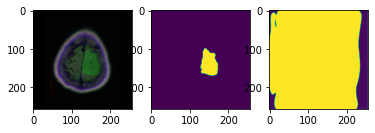

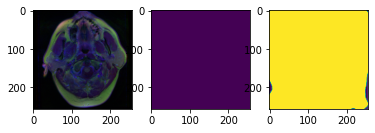

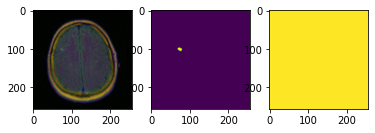

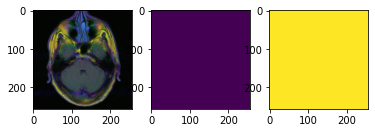

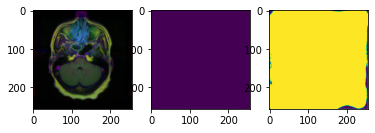

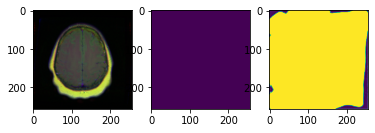

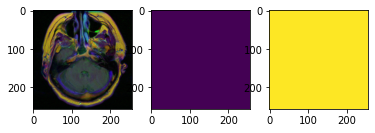

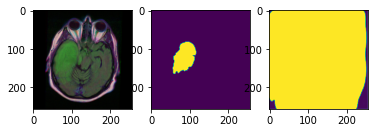

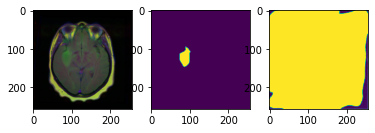

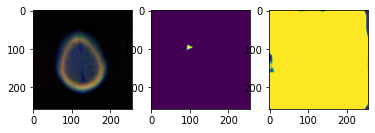

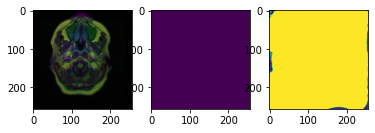

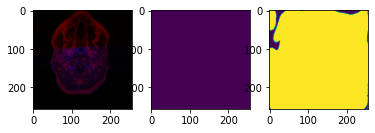

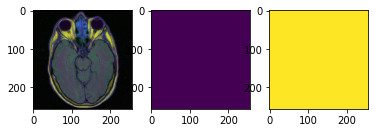

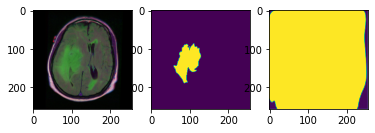

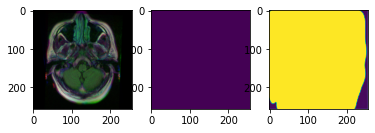

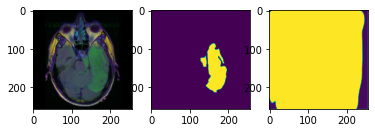

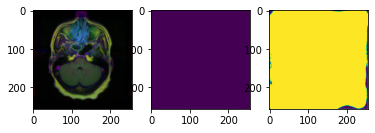

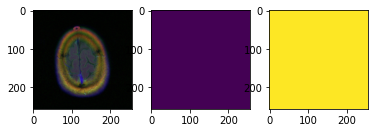

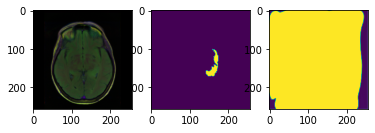

In [ ]:
for i in range(20):
  plt.subplot(1,3,1)
  plt.imshow(images[i])
  plt.subplot(1,3,2)
  plt.imshow(labels[i].squeeze())
  plt.subplot(1,3,3)
  plt.imshow((temp_y_[i]).squeeze())
  plt.show()

# MNET

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, UpSampling2D
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K


def getFPDMNet(patchHeight, patchWidth, ipCh, outCh):

    # Input
    input1 = Input((patchHeight, patchWidth, ipCh))

    # Encoder
    conv1 = Conv2D(16, (3, 3), padding='same')(input1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Dropout(0.2)(conv1)

    conv1 = concatenate([input1, conv1], axis=-1)
    conv1 = Conv2D(16, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    #
    input2 = MaxPooling2D(pool_size=(2, 2))(input1)
    conv21 = concatenate([input2, pool1], axis=-1)

    conv2 = Conv2D(32, (3, 3), padding='same')(conv21)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Dropout(0.2)(conv2)

    conv2 = concatenate([conv21, conv2], axis=-1)
    conv2 = Conv2D(32, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    #
    input3 = MaxPooling2D(pool_size=(2, 2))(input2)
    conv31 = concatenate([input3, pool2], axis=-1)

    conv3 = Conv2D(64, (3, 3), padding='same')(conv31)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Dropout(0.2)(conv3)
    
    conv3 = concatenate([conv31, conv3], axis=-1)
    conv3 = Conv2D(64, (3, 3), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    #
    input4 = MaxPooling2D(pool_size=(2, 2))(input3)
    conv41 = concatenate([input4, pool3], axis=-1)

    conv4 = Conv2D(128, (3, 3), padding='same')(conv41)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Dropout(0.2)(conv4)
    
    conv4 = concatenate([conv41, conv4], axis=-1)
    conv4 = Conv2D(128, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Dropout(0.2)(conv4)

    conv4 = Conv2D(128, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    # Decoder
    conv5 = UpSampling2D(size=(2, 2))(conv4)
    conv51 = concatenate([conv3, conv5], axis=-1)

    conv5 = Conv2D(64, (3, 3), padding='same')(conv51)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Dropout(0.2)(conv5)
    
    conv5 = concatenate([conv51, conv5], axis=-1)
    conv5 = Conv2D(64, (3, 3), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    #
    conv6 = UpSampling2D(size=(2, 2))(conv5)
    conv61 = concatenate([conv2, conv6], axis=-1)

    conv6 = Conv2D(32, (3, 3), padding='same')(conv61)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Dropout(0.2)(conv6)
    
    conv6 = concatenate([conv61, conv6], axis=-1)
    conv6 = Conv2D(32, (3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    #
    conv7 = UpSampling2D(size=(2, 2))(conv6)
    conv71 = concatenate([conv1, conv7], axis=-1)

    conv7 = Conv2D(16, (3, 3), padding='same')(conv71)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Dropout(0.2)(conv7)
    
    conv7 = concatenate([conv71, conv7], axis=-1)
    conv7 = Conv2D(16, (3, 3), padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    # Final
    conv81 = UpSampling2D(size=(8, 8))(conv4)
    conv82 = UpSampling2D(size=(4, 4))(conv5)
    conv83 = UpSampling2D(size=(2, 2))(conv6)
    conv8 = concatenate([conv81, conv82, conv83, conv7], axis=-1)
    conv8 = Conv2D(outCh, (1, 1), activation='sigmoid')(conv8)

    ############
    model = Model(inputs=input1, outputs=conv8)

    # sgd = SGD(learning_rate=lrate, decay=decay_Rate, momentum=0.75, nesterov=True)
    # model.compile(optimizer=sgd, loss=my_loss)

    return model

## 모델 컴파일과 학습

In [ ]:
# 모델 생성
# model = unet()
model = getFPDMNet(patchHeight=256, patchWidth=256, ipCh=3, outCh=1)

# 모델 컴파일
# model.compile(loss="mse", optimizer="SGD", metrics=['accuracy'])

lrate = 0.1
decay_Rate = 1e-6

def my_loss(y_true, y_pred):
    l1_loss = K.mean(K.abs(y_pred - y_true))
    return l1_loss
sgd = SGD(learning_rate=lrate, decay=decay_Rate, momentum=0.75, nesterov=True)
model.compile(optimizer=sgd, loss=my_loss, metrics=['accuracy'])


# 학습
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=20, batch_size=8, verbose=1)


Epoch 1/20
33/33 [==============================] - 370s 11s/step - loss: 0.0347 - accuracy: 0.9800 - val_loss: 0.1492 - val_accuracy: 0.9946
Epoch 2/20
33/33 [==============================] - 387s 12s/step - loss: 0.0119 - accuracy: 0.9889 - val_loss: 0.0447 - val_accuracy: 0.9946
Epoch 3/20
33/33 [==============================] - 366s 11s/step - loss: 0.0117 - accuracy: 0.9889 - val_loss: 0.0186 - val_accuracy: 0.9946
Epoch 4/20
33/33 [==============================] - 366s 11s/step - loss: 0.0115 - accuracy: 0.9889 - val_loss: 0.0111 - val_accuracy: 0.9946
Epoch 5/20
33/33 [==============================] - 361s 11s/step - loss: 0.0115 - accuracy: 0.9889 - val_loss: 0.0084 - val_accuracy: 0.9946
Epoch 6/20
33/33 [==============================] - 359s 11s/step - loss: 0.0114 - accuracy: 0.9889 - val_loss: 0.0073 - val_accuracy: 0.9946
Epoch 7/20
33/33 [==============================] - 361s 11s/step - loss: 0.0114 - accuracy: 0.9889 - val_loss: 0.0067 - val_accuracy: 0.9946
Epoch 

In [ ]:
test_x.shape

(109, 256, 256, 3)

In [ ]:
model.save('mri_model.h5')

In [ ]:
!cp /content/MRI_images.zip /content/drive/MyDrive/모델

## 저장한 모델 불러오기

In [ ]:
!cp /content/drive/MyDrive/모델/save.h5 ./

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('save.h5')

In [ ]:
import cv2 
resized = []
for i in range(len(test_x)):
  temp = cv2.resize(test_x[i], dsize = (45,45))
  resized.append(temp)
resized = np.array(resized)
print(resized.shape)

(109, 45, 45, 3)


In [ ]:
y_ = model.predict(test_x)

ValueError: ignored